In [ ]:
!pip install git+https://github.com/albumentations-team/albumentations.git

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-axof6hxc
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-axof6hxc
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98174 sha256=f7b66fa61b9cc617d14fd94be0172b844b82ca4be3905bb36a5061a0c6f1e88b
  Stored in directory: /tmp/pip-ephem-wheel-cache-gq7carqq/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Let's visualize some of the images
%matplotlib inline
import cv2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm 

from torch.optim.lr_scheduler import StepLR,OneCycleLR

In [ ]:
class Transforms:
    def __init__(self, transforms: A.Compose):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))

### **Data Exploration**

In [ ]:
train_data = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor()]
    )
)

print(train_data.data.mean(axis=(0, 1, 2))/255)


Extracting ./data/cifar-10-python.tar.gz to ./data
[0.49139968 0.48215841 0.44653091]


In [ ]:
len(train_data)

50000

In [ ]:
train_data.data.shape

(50000, 32, 32, 3)

### **Transformations**

* **Transformations used on Train Data**
  * Horizontal Flip
  * ShiftScaleRotate
  * Coarse Dropout

* References:
  * [albumentation_doocs](https://albumentations.ai/docs/examples/pytorch_classification/)
  * [video_tutorial](https://www.youtube.com/watch?v=rAdLwKJBvPM&ab_channel=AladdinPersson)
  * [albumentations_classes](https://albumentations.ai/docs/api_reference/augmentations/transforms/)

In [ ]:
train_transform = A.Compose([
            A.HorizontalFlip(p=0.3),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_REFLECT_101, always_apply=False, p=0.5),
            A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=(0.4914, 0.4822, 0.4465), mask_fill_value = None),
            A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
            ToTensorV2(),
        ])

test_transform = A.Compose([
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
    ToTensorV2(),
])

In [ ]:
SEED = 42

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [ ]:
train_transform = Transforms(train_transform)
test_transform = Transforms(test_transform)

### **Download And Load Train, Test Data**

In [ ]:
train = datasets.CIFAR10(root='./data', train=True,
                        download=True, transform=train_transform)
test = datasets.CIFAR10(root='./data', download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train, 
                                          batch_size=128, 
                                          shuffle=True,
                                          num_workers=2, 
                                          pin_memory=True)
test_loader = torch.utils.data.DataLoader(test, 
                                          batch_size=128,  
                                          shuffle=False,
                                          num_workers=2, 
                                          pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
use_cuda = torch.cuda.is_available()
device = 'cuda:0' if use_cuda else 'cpu'

### **Model Design**

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

### **Model Summary**

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

### **Train Function**

In [ ]:
def train(model, device, train_loader, optimizer, scheduler, criterion, train_acc, train_loss):   
    model.train()
    pbar = tqdm(train_loader)

    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data["image"].to(device), target.to(device)

        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = criterion(y_pred, target)

        train_loss.append(loss.data.cpu().numpy().item())

        # Backpropagation
        loss.backward()

        optimizer.step()
        scheduler.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(
            desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100 * correct / processed:0.2f}')
        train_acc.append(100 * correct / processed)

### **Test Function**

In [ ]:
def test(model, device, test_loader, test_acc, test_losses):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data["image"].to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

### **Train And Test the Model**

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.7)
scheduler = OneCycleLR(optimizer, max_lr=0.015, epochs=20, steps_per_epoch=len(train_loader))

train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for epoch in range(1, 21):
    print(f'Epoch {epoch}:')
    train(model, device, train_loader, optimizer,scheduler,criterion, train_accuracy, train_losses)

    test(model, device, test_loader,test_accuracy, test_losses)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1:


Loss=1.3807648420333862 Batch_id=390 Accuracy=37.83: 100%|██████████| 391/391 [01:04<00:00,  6.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 27478/50000 (54.96%)

Epoch 2:


Loss=1.2307568788528442 Batch_id=390 Accuracy=52.55: 100%|██████████| 391/391 [01:04<00:00,  6.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 30665/50000 (61.33%)

Epoch 3:


Loss=1.1359974145889282 Batch_id=390 Accuracy=59.25: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 33381/50000 (66.76%)

Epoch 4:


Loss=0.8834953308105469 Batch_id=390 Accuracy=64.96: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 35588/50000 (71.18%)

Epoch 5:


Loss=0.846274733543396 Batch_id=390 Accuracy=69.05: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 39021/50000 (78.04%)

Epoch 6:


Loss=0.7453653812408447 Batch_id=390 Accuracy=72.04: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 37485/50000 (74.97%)

Epoch 7:


Loss=0.4584648013114929 Batch_id=390 Accuracy=74.70: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 41081/50000 (82.16%)

Epoch 8:


Loss=0.6761376261711121 Batch_id=390 Accuracy=76.38: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 41987/50000 (83.97%)

Epoch 9:


Loss=0.46041959524154663 Batch_id=390 Accuracy=78.02: 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 43357/50000 (86.71%)

Epoch 10:


Loss=0.8709599375724792 Batch_id=390 Accuracy=79.31: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 44657/50000 (89.31%)

Epoch 11:


Loss=0.5557038187980652 Batch_id=390 Accuracy=80.51: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 44658/50000 (89.32%)

Epoch 12:


Loss=0.4747753143310547 Batch_id=390 Accuracy=81.60: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 45678/50000 (91.36%)

Epoch 13:


Loss=0.49158453941345215 Batch_id=390 Accuracy=82.87: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 46076/50000 (92.15%)

Epoch 14:


Loss=0.4296746253967285 Batch_id=390 Accuracy=84.11: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 47022/50000 (94.04%)

Epoch 15:


Loss=0.3189294934272766 Batch_id=390 Accuracy=85.04: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 47053/50000 (94.11%)

Epoch 16:


Loss=0.4269600808620453 Batch_id=390 Accuracy=86.27: 100%|██████████| 391/391 [01:05<00:00,  5.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 48017/50000 (96.03%)

Epoch 17:


Loss=0.36634740233421326 Batch_id=390 Accuracy=87.64: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 48536/50000 (97.07%)

Epoch 18:


Loss=0.48459696769714355 Batch_id=390 Accuracy=88.61: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 48977/50000 (97.95%)

Epoch 19:


Loss=0.4799357056617737 Batch_id=390 Accuracy=89.47: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 49135/50000 (98.27%)

Epoch 20:


Loss=0.36189454793930054 Batch_id=390 Accuracy=89.84: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]



Test set: Average loss: 0.0005, Accuracy: 49156/50000 (98.31%)



### **Train, Validation Loss and Accuracy Plots**

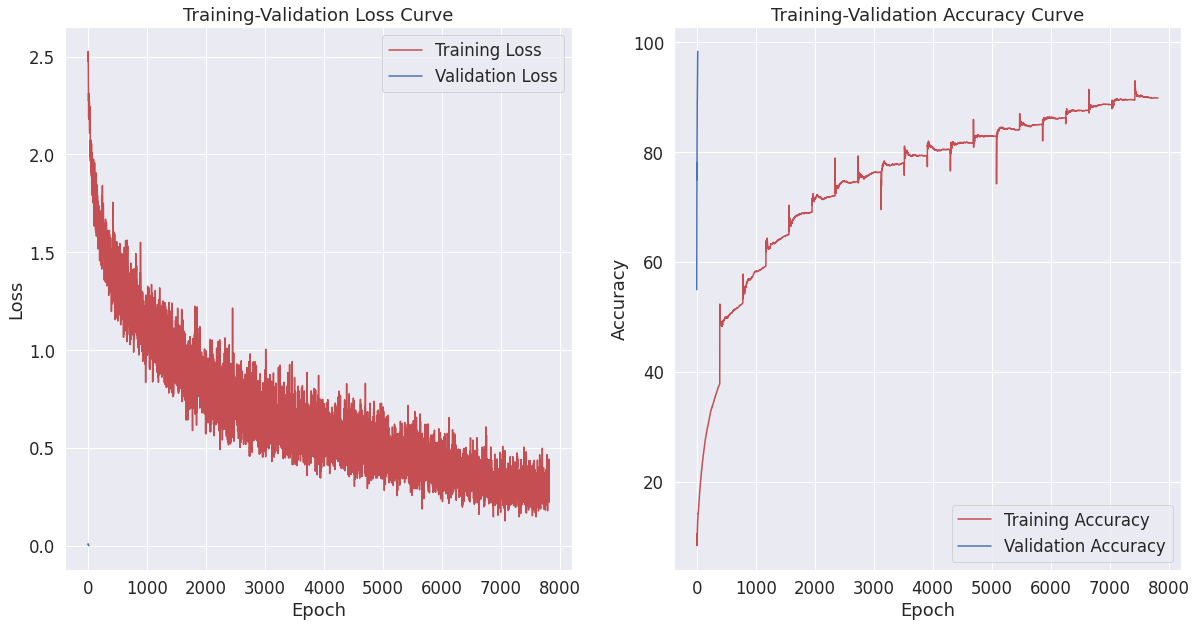

In [ ]:
import seaborn as sns

sns.set(style='whitegrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (20,10)

# Plot the learning curve.
fig, (plt1,plt2) = plt.subplots(1,2)
plt1.plot(train_losses, 'r', label="Training Loss")
plt1.plot(test_losses, 'b', label="Validation Loss")
plt2.plot(train_accuracy, 'r', label="Training Accuracy")
plt2.plot(test_accuracy, 'b', label="Validation Accuracy")

plt2.set_title("Training-Validation Accuracy Curve")
plt2.set_xlabel("Epoch")
plt2.set_ylabel("Accuracy")
plt2.legend()
plt1.set_title("Training-Validation Loss Curve")
plt1.set_xlabel("Epoch")
plt1.set_ylabel("Loss")
plt1.legend()

plt.show()

### **Classwise Predictions**

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images["image"].to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 96 %
Accuracy of   cat : 94 %
Accuracy of  deer : 96 %
Accuracy of   dog : 95 %
Accuracy of  frog : 98 %
Accuracy of horse : 97 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %


In [ ]:
wrong_images = []
wrong_label = []
correct_label = []
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data["image"].to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True).squeeze()

        wrong_pred = (pred.eq(target.view_as(pred)) == False)
        wrong_images.append(data[wrong_pred])
        wrong_label.append(pred[wrong_pred])
        correct_label.append(target.view_as(pred)[wrong_pred])

        wrong_predictions = list(zip(torch.cat(wrong_images), torch.cat(wrong_label), torch.cat(correct_label)))
    print(f'Total wrong predictions are {len(wrong_predictions)}')

Total wrong predictions are 844


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

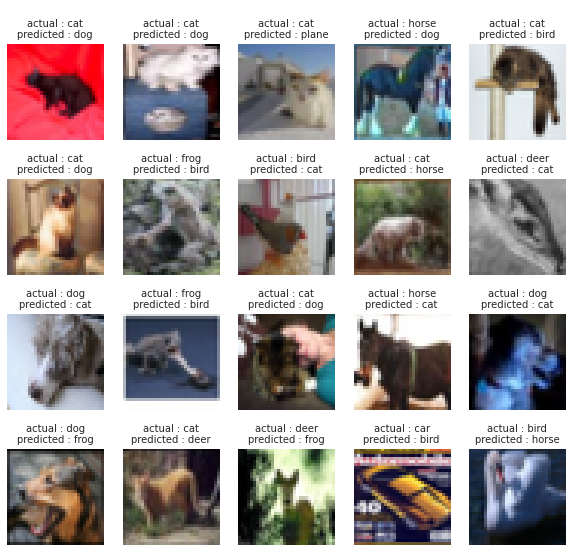

In [ ]:
fig = plt.figure(figsize=(10, 12))
fig.tight_layout()

mean = (0.49139968, 0.48215841, 0.44653091)
std = (0.24703223, 0.24348513, 0.26158784)

for i, (img, pred, correct) in enumerate(wrong_predictions[:20]):
    img, pred, target = img.cpu().numpy().astype(dtype=np.float32), pred.cpu(), correct.cpu()
    for j in range(img.shape[0]):
        img[j] = (img[j] * std[j]) + mean[j]

    img = np.transpose(img, (1, 2, 0))  # / 2 + 0.5
    ax = fig.add_subplot(5, 5, i + 1)
    ax.axis('off')
    ax.set_title(f'\nactual : {classes[target.item()]}\npredicted : {classes[pred.item()]}',
                  fontsize=10)
    ax.imshow(img)

plt.show()